In [18]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [19]:
training_dataset_path = "./10monkeys/training/training"
test_dataset_path = "./10monkeys/validation/validation"

In [20]:
# could import the get_mean_and_std function here instead
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

In [21]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [22]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=test_transforms)

In [23]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0857832..3.2935688].


labels:  tensor([2, 5, 3, 9, 7, 6])


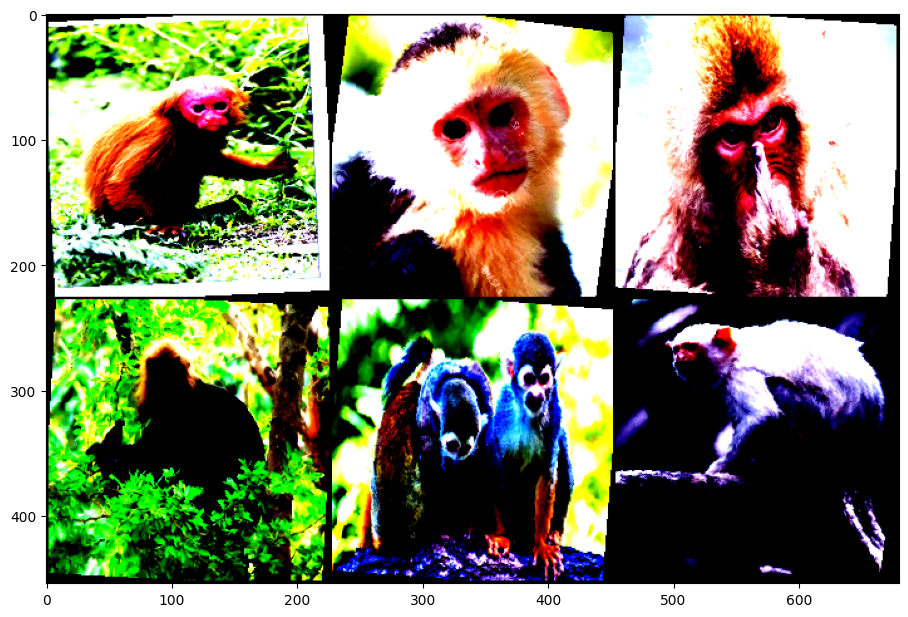

In [24]:
show_transformed_images(train_dataset)

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [26]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

CUDA is available.
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4080 SUPER


In [27]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [28]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()

    for epoch in range(n_epochs):
        print("Epoch Number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print("    Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
        % (running_correct, total, epoch_acc, epoch_loss))

        evaluate_model_on_test_set(model, test_loader)

    print("Finished")
    return model

In [29]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    
    print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc))



In [30]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_19_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

/home/etharialle/venv/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etharialle/venv/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/etharialle/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.2MB/s]


In [31]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 10)

Epoch Number 1 
    Training dataset. Got 856 out of 1097 images correctly (78.031%). Epoch loss: 0.697
    - Testing dataset. Got 254 out of 272 images correctly (93.382%)
Epoch Number 2 
    Training dataset. Got 1066 out of 1097 images correctly (97.174%). Epoch loss: 0.101
    - Testing dataset. Got 262 out of 272 images correctly (96.324%)
Epoch Number 3 
    Training dataset. Got 1077 out of 1097 images correctly (98.177%). Epoch loss: 0.066
    - Testing dataset. Got 263 out of 272 images correctly (96.691%)
Epoch Number 4 
    Training dataset. Got 1089 out of 1097 images correctly (99.271%). Epoch loss: 0.027
    - Testing dataset. Got 265 out of 272 images correctly (97.426%)
Epoch Number 5 
    Training dataset. Got 1095 out of 1097 images correctly (99.818%). Epoch loss: 0.012
    - Testing dataset. Got 269 out of 272 images correctly (98.897%)
Epoch Number 6 
    Training dataset. Got 1092 out of 1097 images correctly (99.544%). Epoch loss: 0.016
    - Testing dataset. Got

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  